In [43]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [44]:
dataset=pd.read_csv('Dataset/creditcard.csv')

In [32]:
dataset.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [34]:
dataset.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [36]:
dataset.head(-100)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284702,172696.0,-0.481672,1.579297,-1.284154,-0.083524,0.097815,-1.421216,0.265490,0.528140,-0.307906,...,0.388981,0.931019,-0.114448,-0.196205,-0.350532,-0.156168,-0.242231,-0.000290,2.32,0
284703,172699.0,1.019594,-1.956473,-1.431268,0.539727,-0.499995,0.301251,0.326079,-0.062475,1.121288,...,-0.081894,-1.202749,-0.182683,-1.075679,-0.417648,-1.080842,-0.049144,0.039078,521.90,0
284704,172700.0,-1.269721,1.555504,0.131330,-1.065236,0.107397,-0.307148,0.001854,0.678313,0.459493,...,-0.254000,-0.744358,-0.155462,-1.143492,-0.136877,-0.245317,-0.315736,-0.135902,0.77,0
284705,172700.0,1.661170,-0.776159,-0.641425,0.373346,-0.503214,-0.187082,-0.217116,-0.029741,0.842554,...,-0.093155,-0.490798,0.179927,-0.428102,-0.448987,-0.678428,0.000639,-0.015738,169.29,0


In [37]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [38]:
total_null_values=dataset.isnull().sum().sort_values(ascending=False)
total_null_values

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

Text(0, 0.5, 'count')

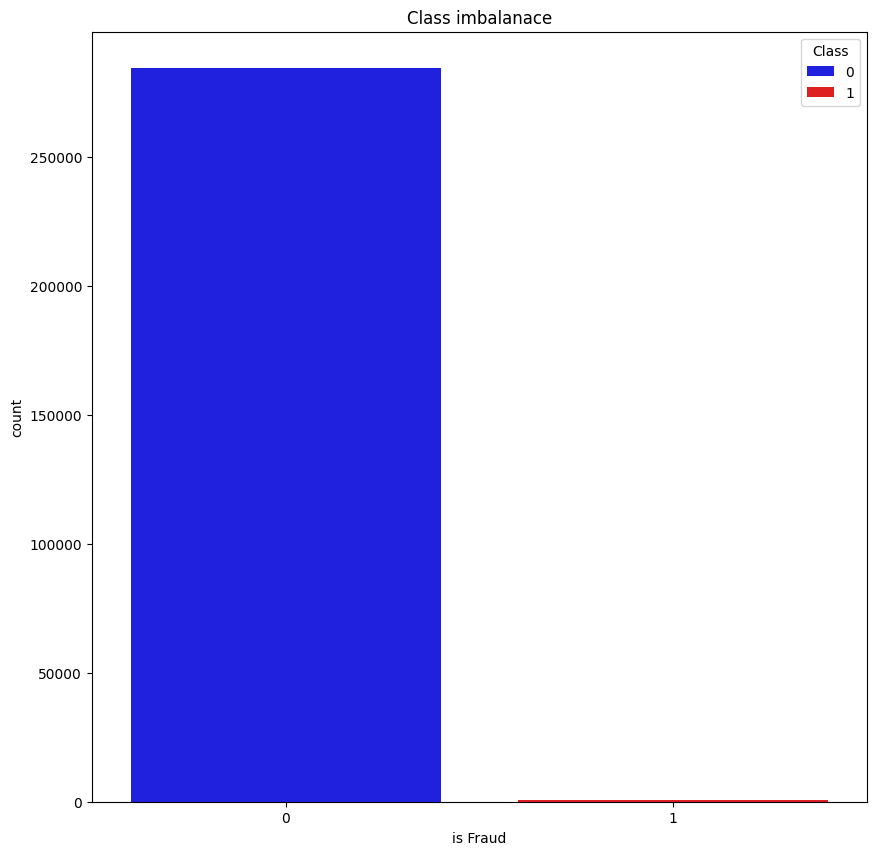

In [48]:
palette1={0:'blue',1:'red'}
plt.figure(figsize=(10,10))
sns.countplot(x='Class',data=dataset,hue='Class',palette=palette1)
plt.title("Class imbalanace")
plt.xlabel('is Fraud')
plt.ylabel('count')

For checking the imbalance in the data set

C:\Users\HP\AppData\Local\Temp\ipykernel_7668\3465083911.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\HP\AppData\Local\Temp\ipykernel_7668\3465083911.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




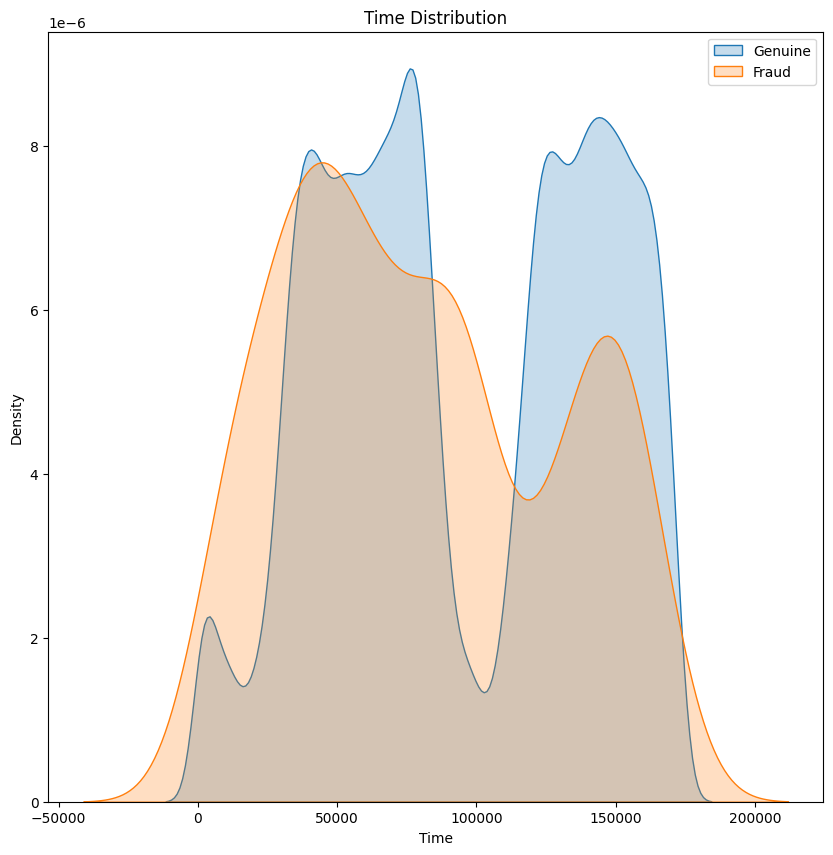

In [49]:
plt.figure(figsize=(10,10))
sns.kdeplot(dataset.loc[dataset['Class']==0]['Time'],label='Genuine',shade=True)
sns.kdeplot(dataset[dataset['Class']==1]['Time'],label='Fraud',shade=True)
plt.title('Time Distribution')
plt.xlabel('Time')
plt.ylabel('Density')
plt.legend()


Checking the relation between Fraud transaction based on the count of the Transactions


In [15]:
plt.figure(figsize=(10,5))
palette={0:"blue",1:"red"}
count_feature=['count1h','count1d','count7d','c']

<Figure size 1000x500 with 0 Axes>

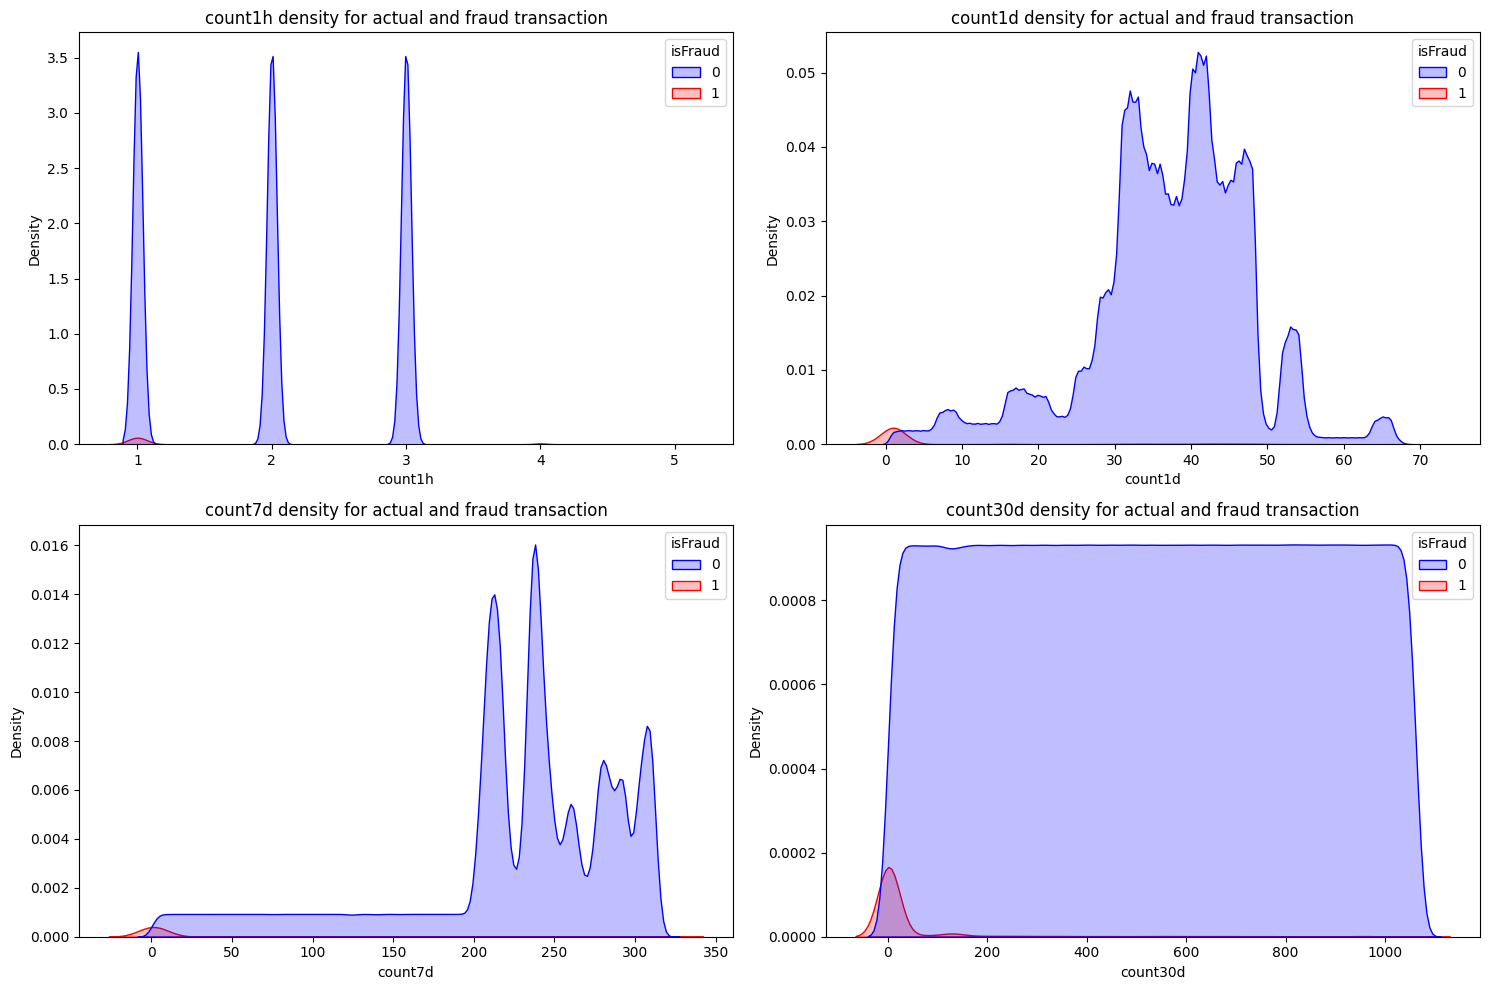

In [16]:
plt.figure(figsize=(15, 10))

# Subplot 1 - count1h
plt.subplot(2, 2, 1)
sns.kdeplot(data=dataset, x='count1h', hue='isFraud', fill=True, palette=palette)
plt.title('count1h density for actual and fraud transaction')

# Subplot 2 - count1d
plt.subplot(2, 2, 2)
sns.kdeplot(data=dataset, x='count1d', hue='isFraud', fill=True, palette=palette)
plt.title('count1d density for actual and fraud transaction')

# Subplot 3 - count7d
plt.subplot(2, 2, 3)
sns.kdeplot(data=dataset, x='count7d', hue='isFraud', fill=True, palette=palette)
plt.title('count7d density for actual and fraud transaction')

# Subplot 4 - count30d
plt.subplot(2, 2, 4)
sns.kdeplot(data=dataset, x='count30d', hue='isFraud', fill=True, palette=palette)
plt.title('count30d density for actual and fraud transaction')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Relation between Amount and the Fraudulent

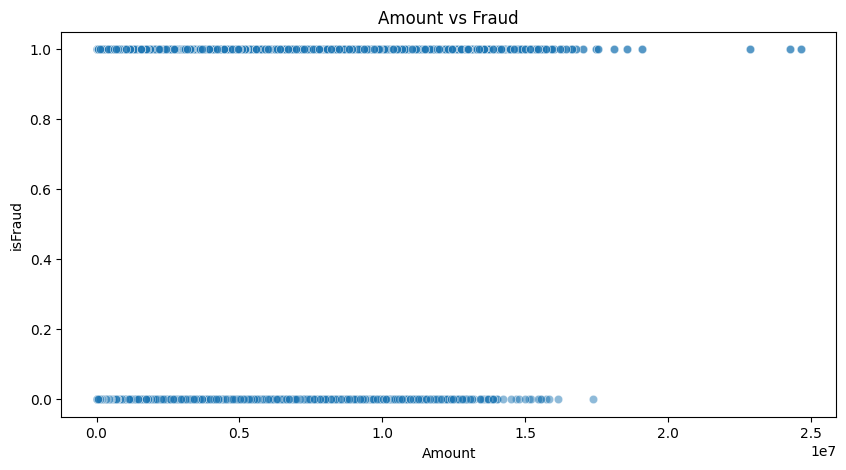

In [17]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=dataset,x='amount',y='isFraud',alpha=0.5)
plt.title('Amount vs Fraud')
plt.xlabel('Amount')
plt.ylabel('isFraud')
plt.show()

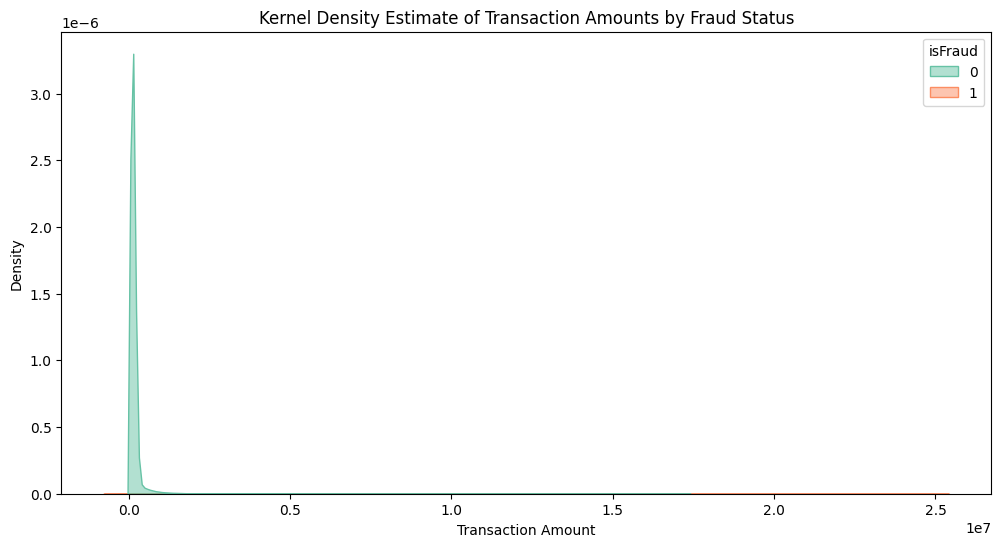

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a KDE plot for transaction amounts
sns.kdeplot(data=dataset, x='amount', hue='isFraud', fill=True, palette="Set2", alpha=0.5)

# Adding titles and labels
plt.title('Kernel Density Estimate of Transaction Amounts by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')

# Show the plot
plt.show()


Normalizing the amount

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

dataset['normalised_Amount']=scaler.fit_transform(dataset[['amount']])

In [20]:
dataset['normalised_Amount']

0          0.000002
1          0.000002
2          0.000012
3          0.000012
4          0.000001
             ...   
5420476    0.005275
5420477    0.063736
5420478    0.063736
5420479    0.041650
5420480    0.041650
Name: normalised_Amount, Length: 5420481, dtype: float64

<Axes: xlabel='normalised_Amount', ylabel='Density'>

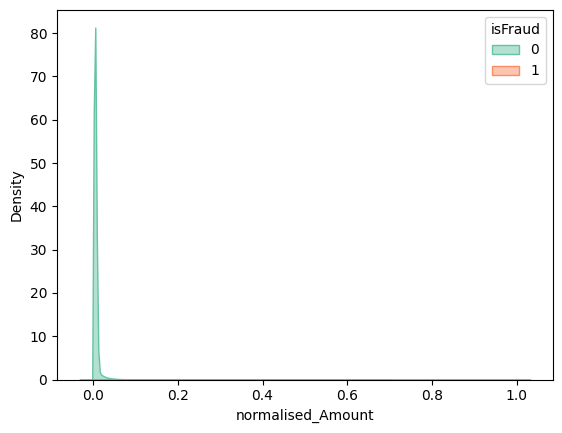

In [21]:
sns.kdeplot(data=dataset,x='normalised_Amount',hue='isFraud',fill=True,palette='Set2',alpha=0.5)

In [22]:
dataset['time_x']

0          1.000000
1          1.000000
2          1.000000
3          1.000000
4          1.000000
             ...   
5420476    0.965926
5420477    0.965926
5420478    0.965926
5420479    0.965926
5420480    0.965926
Name: time_x, Length: 5420481, dtype: float64

In [24]:
max(dataset['time_x'])
#min(dataset['time_x'])

1.0

In [26]:
#max(dataset['time_y'])
min(dataset['time_y'])

-1.0

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


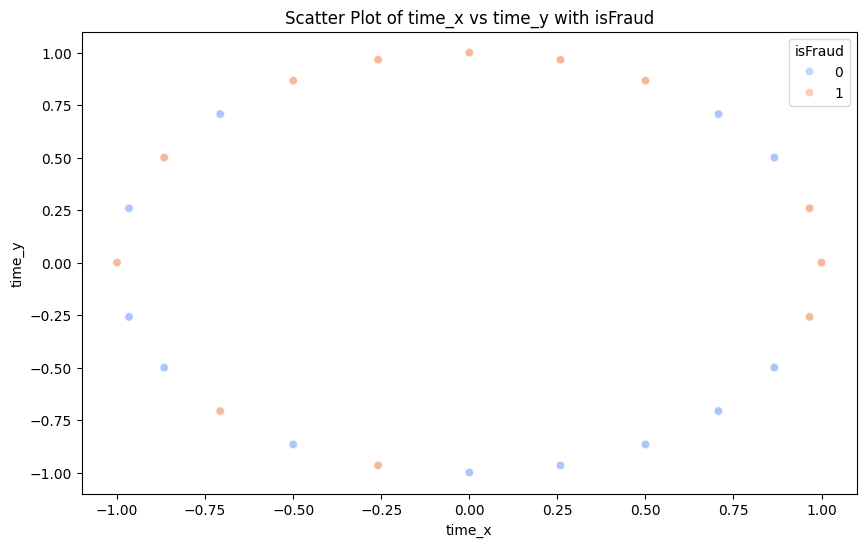

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='time_x', y='time_y', hue='isFraud', palette='coolwarm', alpha=0.7)
plt.title('Scatter Plot of time_x vs time_y with isFraud')
plt.xlabel('time_x')
plt.ylabel('time_y')
plt.legend(title='isFraud')
plt.show()


In [29]:
corr_matrix=dataset[['time_x','time_y','isFraud']].corr()

In [30]:
corr_matrix

,time_x,time_y,isFraud
time_x,1.000000,0.087470,-0.018458
time_y,0.087470,1.000000,0.051566
isFraud,-0.018458,0.051566,1.000000
